In [72]:
import pennylane as qml
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Patch
from itertools import product
from dataclasses import dataclass

import numpy as np

np.set_printoptions(suppress=True)

height = 4
width = 6

all_sites = [(i, j) for i, j in product(range(width), range(height))]

In [73]:
@dataclass(frozen=True)
class Wire:
    i: int
    j: int

example_wire = Wire(0, 0)
print("Example wire: ", example_wire)
print("At coordinates: ", example_wire.i, example_wire.j)


Example wire:  Wire(i=0, j=0)
At coordinates:  0 0


In [74]:
mod = lambda s: Wire(s[0] % width, s[1] % height)

zgroup_sites = []  # list of sites in each group
zgroup_ops = []  # list of operators for each group

for x, y in product(range(width // 2), range(height)):

    x0 = 2 * x + (y + 1) % 2 # x starting coordinate

    sites = [(x0, y), (x0 + 1, y), (x0 + 1, y + 1), (x0, y + 1)]

    op = qml.operation.Tensor(*(qml.PauliZ(mod(s)) for s in sites))

    zgroup_sites.append(sites)
    zgroup_ops.append(op)

print("First set of sites: ", zgroup_sites[0])
print("First operator: ", zgroup_ops[0])

First set of sites:  [(1, 0), (2, 0), (2, 1), (1, 1)]
First operator:  PauliZ(wires=[Wire(i=1, j=0)]) @ PauliZ(wires=[Wire(i=2, j=0)]) @ PauliZ(wires=[Wire(i=2, j=1)]) @ PauliZ(wires=[Wire(i=1, j=1)])


In [75]:
xgroup_sites = []
xgroup_ops = []
for x, y in product(range(width // 2), range(height)):
    x0 = 2 * x + y % 2 # lower x coordinate

    sites = [(x0 + 1, y + 1), (x0, y + 1), (x0, y), (x0 + 1, y)]

    if x == 2 and y == 1:  # change order for state prep later
        sites = sites[1:] + sites[0:1]

    op = qml.operation.Tensor(*(qml.PauliX(mod(s)) for s in sites))

    xgroup_sites.append(sites)
    xgroup_ops.append(op)

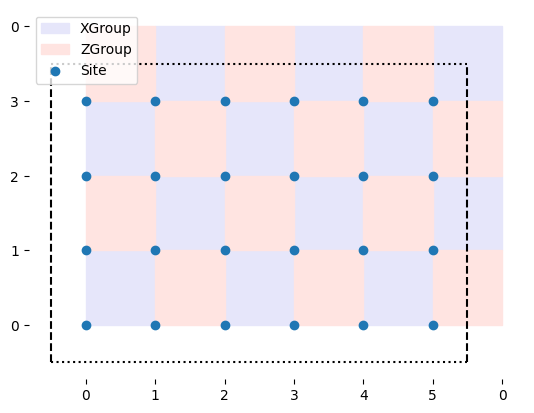

In [76]:
def misc_plot_formatting(fig, ax):
    plt.hlines([-0.5, height - 0.5], -0.5, width - 0.5, linestyle="dotted", color="black")
    plt.vlines([-0.5, width - 0.5], -0.5, height - 0.5, linestyle="dashed", color="black")
    plt.xticks(range(width + 1), [str(i % width) for i in range(width + 1)])
    plt.yticks(range(height + 1), [str(i % height) for i in range(height + 1)])

    for direction in ["top", "right", "bottom", "left"]:
        ax.spines[direction].set_visible(False)

    return fig, ax


fig, ax = plt.subplots()
fig, ax = misc_plot_formatting(fig, ax)

for group in xgroup_sites:
    x_patch = ax.add_patch(Polygon(group, color="lavender", zorder=0))

for group in zgroup_sites:
    z_patch = ax.add_patch(Polygon(group, color="mistyrose", zorder=0))

plt_sites = ax.scatter(*zip(*all_sites))

plt.legend([x_patch, z_patch, plt_sites], ["XGroup", "ZGroup", "Site"], loc="upper left")

plt.show()

In [77]:
dev = qml.device("lightning.qubit", wires=[Wire(*s) for s in all_sites])


def state_prep():
    for op in xgroup_ops[0:-1]:
        qml.Hadamard(op.wires[0])
        for w in op.wires[1:]:
            qml.CNOT(wires=[op.wires[0], w])

@qml.qnode(dev, diff_method=None)
def circuit():
    state_prep()
    return [qml.expval(op) for op in xgroup_ops + zgroup_ops]

In [78]:
n_xgroups = len(xgroup_ops)
separate_expvals = lambda expvals: (expvals[:n_xgroups], expvals[n_xgroups:])

xgroup_expvals, zgroup_expvals = separate_expvals(circuit())

E0 = -sum(xgroup_expvals) - sum(zgroup_expvals)

print("X Group expectation values", xgroup_expvals)
print("Z Group expectation values", zgroup_expvals)
print("Total energy: ", E0)

X Group expectation values [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Z Group expectation values [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Total energy:  -23.999999999999996


In [79]:
@qml.qnode(dev, diff_method=None)
def excitations(x_sites, z_sites):
    state_prep()

    for s in x_sites:
        qml.PauliX(Wire(*s))

    for s in z_sites:
        qml.PauliZ(Wire(*s))

    return [qml.expval(op) for op in xgroup_ops + zgroup_ops]

In [80]:
single_x = [(1, 2)]

x_expvals, z_expvals = separate_expvals(excitations(single_x, []))

print("XGroup: ", x_expvals)
print("ZGroup: ", z_expvals)

XGroup:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ZGroup:  [ 1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [81]:
occupation_numbers = lambda expvals: 0.5 * (1 - expvals)

def print_info(x_expvals, z_expvals):
    E = -sum(x_expvals) - sum(z_expvals)

    print("Total energy: ", E)
    print("Energy above the ground state: ", E - E0)
    print("X Group occupation numbers: ", occupation_numbers(x_expvals))
    print("Z Group occupation numbers: ", occupation_numbers(z_expvals))

print_info(x_expvals, z_expvals)

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Z Group occupation numbers:  [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [82]:
def excitation_plot(x_excite, z_excite):
    x_color = lambda expval: "navy" if expval < 0 else "lavender"
    z_color = lambda expval: "maroon" if expval < 0 else "mistyrose"

    fig, ax = plt.subplots()
    fig, ax = misc_plot_formatting(fig, ax)

    for expval, sites in zip(x_excite, xgroup_sites):
        ax.add_patch(Polygon(sites, color=x_color(expval), zorder=0))

    for expval, sites in zip(z_excite, zgroup_sites):
        ax.add_patch(Polygon(sites, color=z_color(expval), zorder=0))

    handles = [
        Patch(color="navy", label="X Group -1"),
        Patch(color="lavender", label="X Group +1"),
        Patch(color="maroon", label="Z Group -1"),
        Patch(color="mistyrose", label="Z Group +1"),
        Patch(color="navy", label="Z op"),
        Patch(color="maroon", label="X op"),
    ]

    plt.legend(handles=handles, ncol=3, loc="lower left")

    return fig, ax

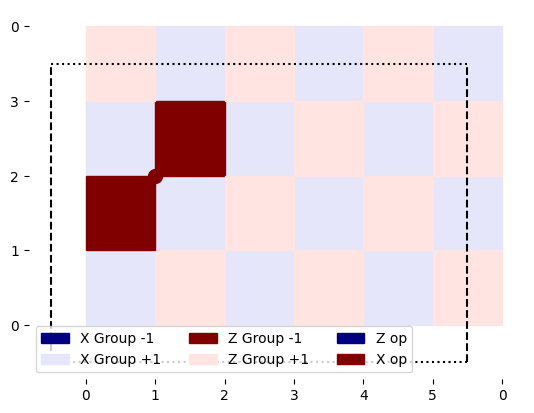

In [83]:
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.scatter(*zip(*single_x), color="maroon", s=100)
plt.show()

In [84]:
single_z = [(1, 2)]

expvals = excitations([], single_z)
x_expvals, z_expvals = separate_expvals(expvals)
print_info(x_expvals, z_expvals)

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Z Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


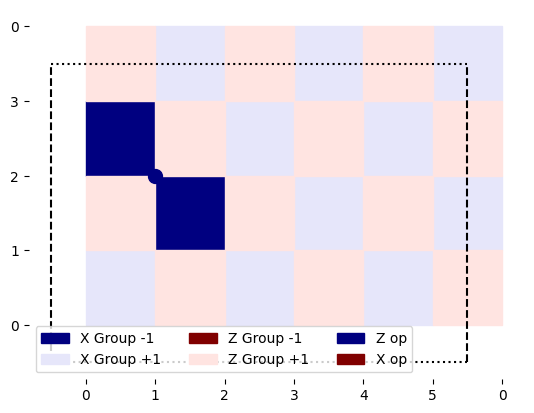

In [85]:
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.scatter(*zip(*single_z), color="navy", s=100)
plt.show()

In [86]:
single_z = [(1, 2)]

expvals = excitations([], single_z + single_z)
x_expvals, z_expvals = separate_expvals(expvals)

print_info(x_expvals, z_expvals)

Total energy:  -23.999999999999996
Energy above the ground state:  0.0
X Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Z Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [87]:
two_z = [(1, 2), (2, 2)]

expvals = excitations([], two_z)
x_expvals, z_expvals = separate_expvals(expvals)

print_info(x_expvals, z_expvals)

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Z Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


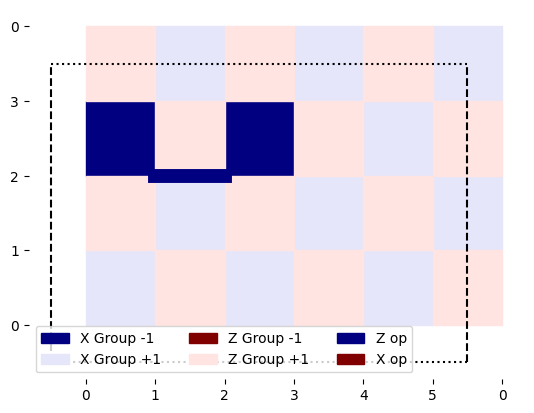

In [88]:
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.plot(*zip(*two_z), color="navy", linewidth=10)
plt.show()

In [89]:
long_string = [(1, 2), (2, 2), (3, 2), (4, 1)]

expvals = excitations([], long_string)
x_expvals, z_expvals = separate_expvals(expvals)

print_info(x_expvals, z_expvals)

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Z Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


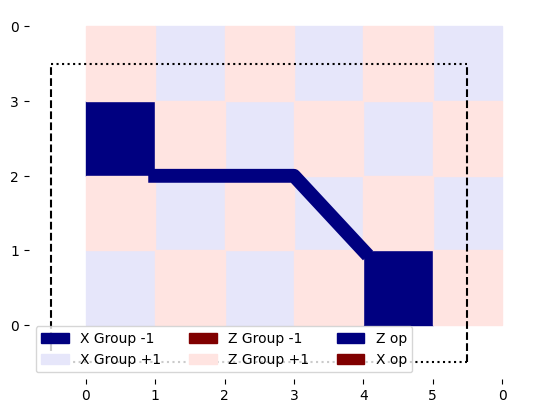

In [90]:
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.plot(*zip(*long_string), color="navy", linewidth=10)
plt.show()

In [91]:
equivalent_string = [(1, 2), (2, 1), (3, 1), (4, 1)]

expvals = excitations([], equivalent_string)
x_expvals, z_expvals = separate_expvals(expvals)

print_info(x_expvals, z_expvals)

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Z Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


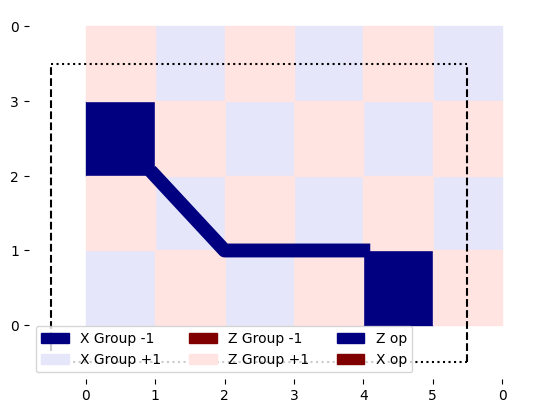

In [92]:
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.plot(*zip(*equivalent_string), color="navy", linewidth=10)
plt.show()

In [93]:
contractible_loop = [(1, 1), (2, 1), (3, 1), (4, 1), (4, 2), (3, 3), (2, 3), (1, 2)]

expvals = excitations(contractible_loop, [])
x_expvals, z_expvals = separate_expvals(expvals)
print_info(x_expvals, z_expvals)

Total energy:  -23.999999999999996
Energy above the ground state:  0.0
X Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Z Group occupation numbers:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


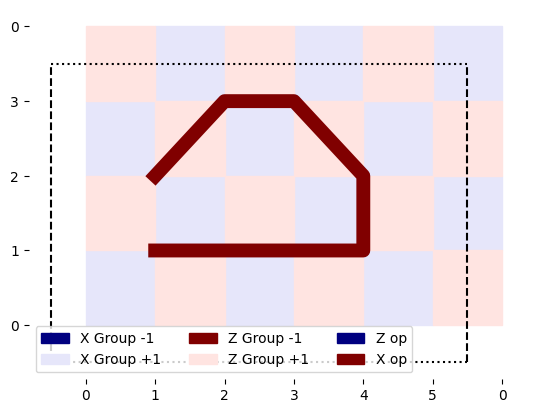

In [94]:
fig, ax = excitation_plot(x_expvals, z_expvals)

ax.plot(*zip(*contractible_loop), color="maroon", linewidth=10)

plt.show()

In [95]:
@qml.qnode(dev, diff_method=None)
def probs(x_sites, z_sites):
    state_prep()

    for s in x_sites:
        qml.PauliX(Wire(*s))

    for s in z_sites:
        qml.PauliZ(Wire(*s))

    return qml.probs(wires=[Wire(*s) for s in all_sites])


null_probs = probs([], [])
contractible_probs = probs(contractible_loop, [])

print("Are the probabilities equal? ", np.allclose(null_probs, contractible_probs))


Are the probabilities equal?  True


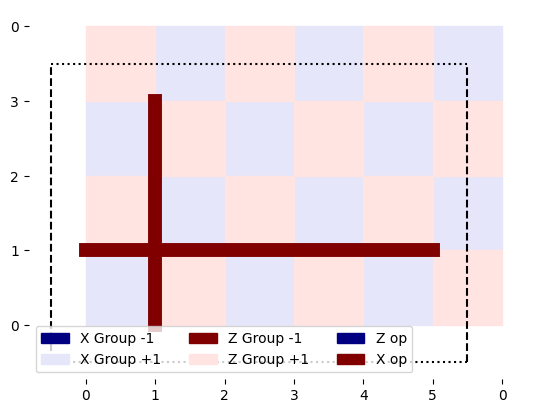

In [96]:
horizontal_loop = [(i, 1) for i in range(width)]
vertical_loop = [(1, i) for i in range(height)]

expvals = excitations(horizontal_loop + vertical_loop, [])
fig, ax = excitation_plot(*separate_expvals(expvals))

ax.plot(*zip(*horizontal_loop), color="maroon", linewidth=10)
ax.plot(*zip(*vertical_loop), color="maroon", linewidth=10)

plt.show()

In [97]:
null_probs = probs([], [])
horizontal_probs = probs(horizontal_loop, [])
vertical_probs = probs(vertical_loop, [])
combo_probs = probs(horizontal_loop + vertical_loop, [])

In [98]:
print("Are the probabilities equal? ", qml.math.allclose(null_probs, horizontal_probs))
print("Is this significant?")
print("Maximum difference in probabilities: ", max(abs(null_probs - horizontal_probs)))
print("Maximum probability: ", max(null_probs))

Are the probabilities equal?  False
Is this significant?
Maximum difference in probabilities:  0.00048828124999999913
Maximum probability:  0.00048828124999999913


In [99]:
probs_type_labels = ["null", "x", "y", "combo"]
all_probs = [null_probs, horizontal_probs, vertical_probs, combo_probs]

print("\t" + "\t".join(probs_type_labels))

for name, probs1 in zip(probs_type_labels, all_probs):
    comparisons = (str(np.allclose(probs1, probs2)) for probs2 in all_probs)
    print(name, "\t", "\t".join(comparisons))

	null	x	y	combo
null 	 True	False	False	False
x 	 False	True	False	False
y 	 False	False	True	False
combo 	 False	False	False	True


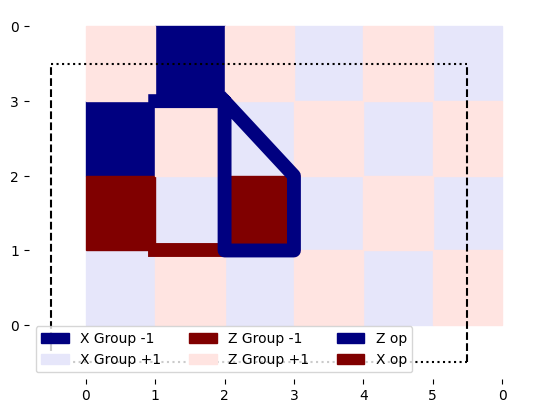

In [100]:
prep1 = [(1, 1), (2, 1)]
prep2 = [(1, 3)]
loop1 = [(2, 3), (2, 2), (2, 1), (3, 1), (3, 2), (2, 3)]

expvals = excitations(prep1, prep2 + loop1)
x_expvals, z_expvals = separate_expvals(expvals)

fig, ax = excitation_plot(x_expvals, z_expvals)

ax.plot(*zip(*prep1), color="maroon", linewidth=10)
ax.plot(*zip(*(prep2 + loop1)), color="navy", linewidth=10)

plt.show()

In [101]:
dev_aux = qml.device("lightning.qubit", wires=[Wire(*s) for s in all_sites] + ["aux"])

def loop(x_loop, z_loop):
    for s in x_loop:
        qml.PauliX(Wire(*s))
    for s in z_loop:
        qml.PauliZ(Wire(*s))

@qml.qnode(dev_aux, diff_method=None)
def hadamard_test(x_prep, z_prep, x_loop, z_loop):
    state_prep()

    for s in x_prep:
        qml.PauliX(Wire(*s))

    for s in z_prep:
        qml.PauliZ(Wire(*s))

    qml.Hadamard("aux")
    qml.ctrl(loop, control="aux")(x_loop, z_loop)
    qml.Hadamard("aux")
    return qml.expval(qml.PauliZ("aux"))

x_around_z = hadamard_test(prep1, prep2, [], loop1)
print("Move x excitation around z excitation: ", x_around_z)

Move x excitation around z excitation:  -0.9999999999999999
